## This version does the ZOGY but computes the kernels in fourier space, and then convolves images in real space.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
x = np.arange(-16, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

In [3]:
import scipy.stats

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = scipy.stats.multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

#g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1])
#plt.imshow(g1)

Make the two "images". `im1` is the template, `im2` is the science image.

NOTE: having sources near the edges really messes up the fitting (probably because of the convolution). So make sure no sources are near the edge.

NOTE: also it seems that having the variable source with a large flux increase also messes up the fitting (seems to lead to overfitting -- perhaps to the source itself). This might be fixed by adding more constant sources.

280 -0.688220756087 -11.6171994264
DescribeResult(nobs=262144, minmax=(-1358.231240709586, 415.11445987856109), mean=-1.9102230795921878e-05, variance=3058.5064469891863, skewness=-9.101008686155017, kurtosis=128.06319735703448)


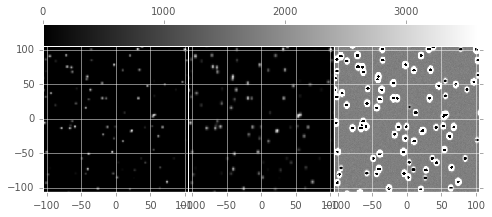

In [4]:
np.random.seed(66)

xim = np.arange(-256, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))
n_sources = 500
fluxes = np.random.uniform(50, 30000, n_sources)
xposns = np.random.uniform(xim.min()+5, xim.max()-5, n_sources)
yposns = np.random.uniform(yim.min()+5, yim.max()-5, n_sources)

# Make the source closest to the center of the image the one that increases in flux
ind = np.argmin(xposns**2. + yposns**2.)
print ind, xposns[ind], yposns[ind]

sig1 = 0.2  # sigma of template
sig2 = 0.2  # sigma of science image
im1 = np.random.normal(scale=sig1, size=x0im.shape)
im2 = np.random.normal(scale=sig2, size=x0im.shape)

psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image. make the psf in this image slighly offset and elongated
offset = 0.0  # 0.2  # astrometric offset in pixels between two images
for i in range(n_sources):
    im1 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i],yposns[i]], s=[psf1, psf1])
    im2 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i]+offset,yposns[i]+offset], s=[psf2, psf2*1.5])
    if i == ind:
        im2 += (fluxes[i]/50.) * gaussian2d(imgrid, m=[xposns[i]+offset,yposns[i]+offset], s=[psf2, psf2*1.5])

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (9, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow((im2-im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - im1, axis=None)

## Compute the FFTs for the "ZOGY" algorithm

In [5]:
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift

DescribeResult(nobs=262144, minmax=(-0.92719462140093301, 3706.1292894132293), mean=28.094248003911815, variance=27655.067390995864, skewness=8.92762151923837, kurtosis=95.88840882524867)
DescribeResult(nobs=262144, minmax=(-0.92719462140096698, 3706.1292894132289), mean=28.094248003911815, variance=27655.067390995864, skewness=8.927621519238366, kurtosis=95.88840882524867)


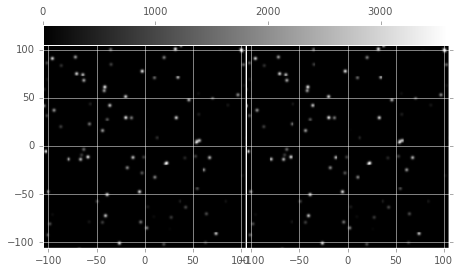

In [6]:
# First compute the science image's (im2's) psf -- easy since we parameterized it above when we made the image
im1_psf = gaussian2d(grid, m=[0, 0], s=[psf1, psf1])
im2_psf = gaussian2d(grid, m=[0, 0], s=[psf2, psf2*1.5])

im1_psf_ft = fft2(im1_psf)
im2_psf_ft = fft2(im2_psf)

im1_ft = fft2(im1)
im2_ft = fft2(im2)

# Just a sanity check:
fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(ifft2(im1_ft).real[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im1, axis=None)
print scipy.stats.describe(ifft2(im1_ft).real, axis=None)

### Now compute the ZOGY eqn. (13):

$$
\widehat{D} = \frac{F_r\widehat{P_r}\widehat{N} - F_n\widehat{P_n}\widehat{R}}{\sqrt{\sigma_n^2 F_r^2 |\widehat{P_r}|^2 + \sigma_r^2 F_n^2 |\widehat{P_n}|^2}}
$$

where $D$ is the optimal difference image, $R$ and $N$ are the reference and "new" image, respectively, $P_r$ and $P_n$ are their PSFs, $F_r$ and $F_n$ are their flux-based zero-points (which we will set to one here), $\sigma_r^2$ and $\sigma_n^2$ are their variance, and $\widehat{D}$ denotes the FT of $D$.

DescribeResult(nobs=262144, minmax=(-11.014876078693419, 35.438382855842292), mean=-6.7536577015931114e-05, variance=1.0395047182447847, skewness=0.9014126146296582, kurtosis=25.1438579147296)


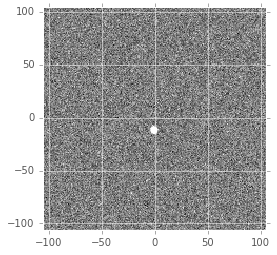

In [7]:
F_r = F_n = 1.
R_hat = fft2(im1)
N_hat = fft2(im2)
P_r = gaussian2d(imgrid, m=[0, 0], s=[psf1, psf1])
P_n = gaussian2d(imgrid, m=[0, 0], s=[psf2, psf2*1.5])
P_r_hat = fft2(P_r)
P_n_hat = fft2(P_n)
d_hat_numerator = (F_r * P_r_hat * N_hat - F_n * P_n_hat * R_hat)
d_hat_denom = np.sqrt((sig1**2 * F_r**2 * np.abs(P_r_hat)**2) + (sig2**2 * F_n**2 * np.abs(P_n_hat)**2))
d_hat = d_hat_numerator / d_hat_denom

d = ifft2(d_hat)
D = np.fft.ifftshift(d.real)
plt.imshow(D[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-4, 4))
print scipy.stats.describe(D, axis=None)

### Compute the PSF of the difference image D (eq. 14):

$$
\widehat{P_D} = \frac{F_r F_n \widehat{P_r} \widehat{P_n}}{F_D \sqrt{\sigma_n^2 F_r^2 |\widehat{P_r}|^2 + \sigma_r^2 F_n^2 |\widehat{P_n}|^2}}
$$

where

$$
F_D = \frac{F_r F_n}{\sqrt{\sigma_n^2 F_r^2 + \sigma_r^2 F_n^2}}
$$

DescribeResult(nobs=262144, minmax=(-0.00024047487788385883, 0.067636466953262503), mean=3.8146972656251474e-06, variance=1.3334160082545696e-07, skewness=124.37568288985155, kurtosis=17332.81542239945)


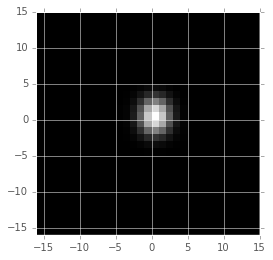

In [8]:
F_D_numerator = F_r * F_n
F_D_denom = np.sqrt(sig1**2 * F_r**2 + sig2**2 * F_n**2)
F_D = F_D_numerator / F_D_denom

P_d_hat_numerator = (F_r * F_n * P_r_hat * P_n_hat)
P_d_hat = P_d_hat_numerator / (F_D * d_hat_denom)

P_d = ifft2(P_d_hat)
P_D = np.fft.ifftshift(P_d.real)
extent = (x0im.min()+240, x0im.max()-240, y0im.min()+240, y0im.max()-240)
x1p, x2p, y1p, y2p = 240, 511-240, 240, 511-240   # limits for display
plt.imshow(P_D[x1p:x2p,y1p:y2p], origin='lower', interpolation='none', cmap='gray', extent=extent) #, clim=(0, 0.67))
print scipy.stats.describe(P_D, axis=None)

Dump the results for comparison with L(ZOGY) in notebook #13.

In [9]:
import cPickle
import gzip
cPickle.dump((im1, im2, im1_psf, im2_psf, D, P_D), gzip.GzipFile("12_results.p.gz", "wb"))

Compute two kernels to convolve im1 and im2 with -- then convolve in image space and subtract. Compare the results.

In [10]:
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift, ifftshift

# Note if we use a smaller PSF (e.g. 32x32) then we get artifacts in the convolution
psfSize = 25
x = np.arange(-psfSize+1, psfSize, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

psf1 = 1.6 #* 5.
psf2 = 2.2 #* 5.
sig1 = sig2 = 0.2
F_r = F_n = 1.0
P_r = gaussian2d(grid, m=[0, 0], s=[psf1, psf1])
P_n = gaussian2d(grid, m=[0, 0], s=[psf2, psf2*1.5])
print sig1, sig2, psf1, psf2
print sig1, sig2, P_r.sum(), P_n.sum()
P_r_hat = fft2(P_r)
P_n_hat = fft2(P_n)
denom = np.sqrt((sig1**2 * F_r**2 * np.abs(P_r_hat)**2) + (sig2**2 * F_n**2 * np.abs(P_n_hat)**2))
K_r_hat = P_r_hat / denom
K_n_hat = P_n_hat / denom
print np.abs(K_r_hat).max(), np.abs(K_r_hat).min(), np.abs(K_r_hat).sum()
#K_r = np.fft.ifftshift(np.abs(ifft2(K_r_hat)).real)
#K_n = np.fft.ifftshift(np.abs(ifft2(K_n_hat)).real)
K_r = ifft2(K_r_hat).real
K_n = ifft2(K_n_hat).real

pck = K_r.real #ifftshift(K_n).real
print K_r.shape, pck.real.shape
print pck.max(), pck.min(), pck.sum()
print np.unravel_index(np.argmax(pck), pck.shape)
print np.unravel_index(np.argmax(P_r), P_r.shape)

0.2 0.2 1.6 2.2
0.2 0.2 1.0 1.0
4.99999999949 3.53553390593 11649.2843439
(49, 49) (49, 49)
4.85184687377 -0.125134411114 3.53553390593
(24, 24)
(24, 24)


LSSTSW has not been set up.
LSSTSW has not been set up.


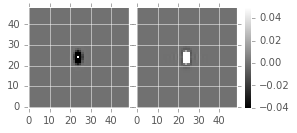

In [11]:
import diffimTests as dit
reload(dit)

dit.plotImageGrid((K_r.real, K_n.real), clim=(-0.04,0.05))

DescribeResult(nobs=262144, minmax=(-4.4606297142333347, 35.438377173642039), mean=7.0688018575501338e-05, variance=1.0380698132836026, skewness=0.9148537267493507, kurtosis=25.104640175358984)


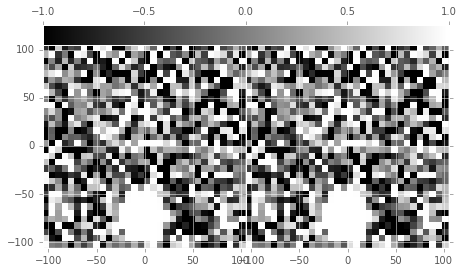

In [12]:
import scipy.ndimage.filters

tmp = K_n.real #[1:,1:]
im1c = scipy.ndimage.filters.convolve(im1, tmp, mode='constant')
tmp = K_r.real #[1:,1:]
im2c = scipy.ndimage.filters.convolve(im2, tmp, mode='constant')
diffim = im2c - im1c
print scipy.stats.describe(diffim, axis=None)

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
#x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
x1d, x2d, y1d, y2d = 240, 512-240, 240, 512-240   # limits for display
#plt.imshow(diffim[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-2.5,2.5)) # corrected diffim
gim = igrid[0].imshow(D[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))
igrid[1].imshow(diffim[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))
igrid.cbar_axes[0].colorbar(gim)

Compare the k-space vs. image-space versions:

-3.9813348154 3.97802807875
260063 260063
0.999347830805 0.999338570309
35.4383828558 35.4383771736
35.4615097601 35.4618326827
31 31


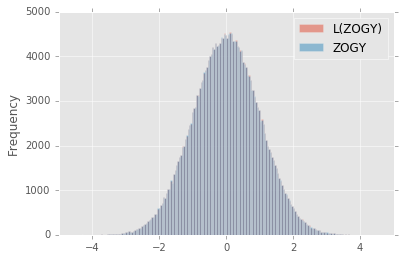

In [13]:
d1 = D
d2 = diffim
# The ZOGY diffim has artefacts on the edges. Let's set them to zero so they dont mess up the stats.
# The ZOGY(real) diffim has zero's at 32 pixels surrounding the image.
# Actually, let's just set the edge pixels of both diffims to zero.
d2[d1 == 0.] = 0.
d1[0,:] = d1[:,0] = d1[-1,:] = d1[:,-1] = 0.
d2[0,:] = d2[:,0] = d2[-1,:] = d2[:,-1] = 0.

import scipy.stats
_, low, upp = scipy.stats.sigmaclip([d1, d2])
print low, upp
low *= 1.1
upp *= 1.1
d2a = d2[(d1>low) & (d1<upp) & (d2>low) & (d2<upp) & (d2!=0.) & (d1!=0.)]
d1a = d1[(d1>low) & (d1<upp) & (d2>low) & (d2<upp) & (d1!=0.)]
print len(d1a.flatten()), len(d2a.flatten())
df = pd.DataFrame({'L(ZOGY)': d1a.flatten()/d1a.std(), 'ZOGY': d2a.flatten()/d2a.std()})
df.plot.hist(alpha=0.5, bins=200)

print d1a.std(), d2a.std()
print d1.max(), d2.max()
print d1.max()/d1a.std(), d2.max()/d2a.std()
print np.sum(d1>d1a.std()*5.), np.sum(d2>d2a.std()*5.)

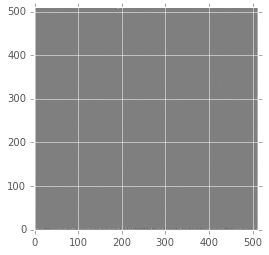

In [14]:
plt.imshow(d1 - d2, origin='lower', interpolation='none', cmap='gray', clim=(-0.1,0.1))

-0.75330558791 0.296271915451 0.00403427121656


(-0.002, 0.002)

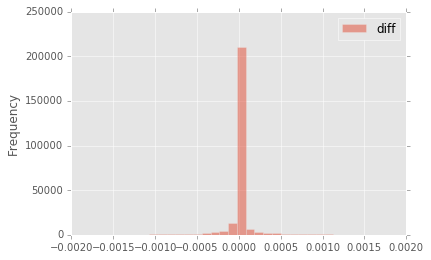

In [15]:
df = pd.DataFrame({'diff': (d1 - d2).flatten()})
df.plot.hist(alpha=0.5, bins=10000)
print df.min()[0], df.max()[0], df.std()[0]
plt.xlim(-0.002, 0.002)

Use the code from `diffimTests.py`.

In [3]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

im1, im2, im1_psf, im2_psf, im1_var, im2_var, changedCentroid = \
    dit.makeFakeImages(xim=None, yim=None, sky=sky, psf1=None, psf2=None, offset=[0., 0.],
                    psf_yvary_factor=0., varSourceChange=1500., theta1=0., theta2=-45., im2background=0.,
                    n_sources=50, sourceFluxRange=(500,30000), seed=66, psfSize=None)
    
_, _, P_r, P_n, _, _, changedCentroid = \
    dit.makeFakeImages(xim=None, yim=None, sky=sky, psf1=None, psf2=None, offset=[0., 0.],
                    psf_yvary_factor=0., varSourceChange=1500., theta1=0., theta2=-45., im2background=0.,
                    n_sources=50, sourceFluxRange=(500,30000), seed=66, psfSize=25)

print dit.computeClippedImageStats(im1)
print dit.computeClippedImageStats(im2)
print dit.computeClippedImageStats(im1_var)
print dit.computeClippedImageStats(im2_var)

LSSTSW has not been set up.
LSSTSW has not been set up.
Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: 0.0 0.0
Variable source: 245.899250131 279.361590046 1423.89964966 2923.89964966
Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: 0.0 0.0
Variable source: 245.899250131 279.361590046 1423.89964966 2923.89964966
(0.058941207521673616, 17.142582277831181, -74.0, 1741.5550996425638)
(0.16735074378053241, 17.213851327082029, -82.0, 1169.0572762553779)
(300.05894120752163, 17.142582277831185, 226.0, 2041.5550996425638)
(300.16735074378062, 17.213851327082025, 218.0, 1469.0572762553779)


In [4]:
reload(dit)
D = dit.performZOGY(im1, im2, im1_psf, im2_psf)
D_AL, _ = dit.performAlardLupton(im1, im2, spatialKernelOrder=0, spatialBackgroundOrder=1)
D_AL /= np.sqrt(sky * 2.)
D_new = dit.performZOGYImageSpace(im1, im2, P_r, P_n)
print dit.computeClippedImageStats(D)
print dit.computeClippedImageStats(D_new)
print dit.computeClippedImageStats(D_AL)

LSSTSW has not been set up.
(-0.00088461625274379168, 0.99323103779662691, -4.8991482476770942, 4.4838170921378442)
(-0.00093387909492429616, 0.99316652235136338, -4.8991388073481676, 4.4849793533753344)
(-0.0032574651151661845, 0.98643447728612821, -4.7439403672840381, 5.8392332955945223)


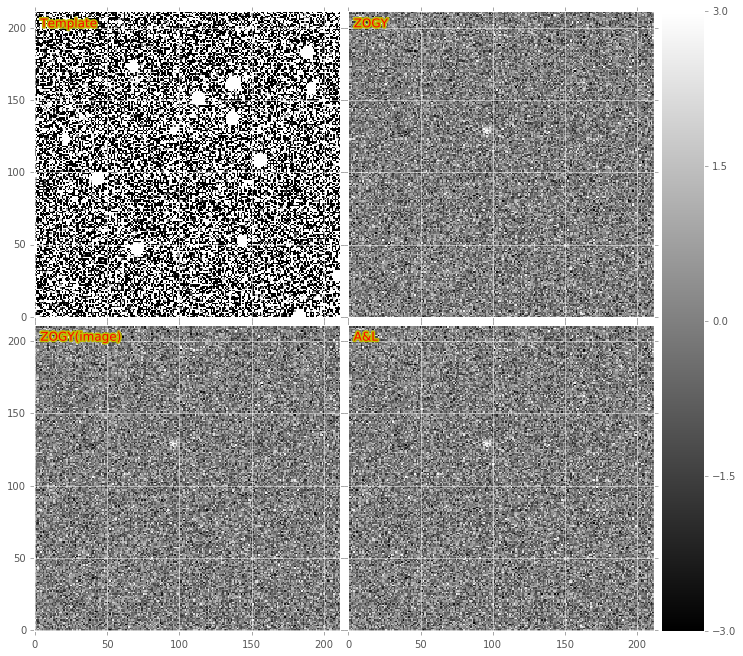

In [6]:
xim = np.arange(-256, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))

fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
dit.plotImageGrid((im1[x1d:x2d,y1d:y2d], D[x1d:x2d,y1d:y2d], D_new[x1d:x2d,y1d:y2d], D_AL[x1d:x2d,y1d:y2d]), 
                  clim=(-3,3), titles=['Template', 'ZOGY', 'ZOGY(image)', 'A&L'])

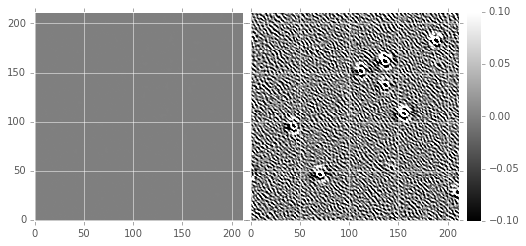

In [7]:
D_new[0,:] = D_new[:,0] = D_new[-1,:] = D_new[:,-1] = 0.
D[D_new == 0] = 0.
D_AL[D_new == 0] = 0.
fig = plt.figure(1, (8, 8))
dit.plotImageGrid(((D - D_new)[x1d:x2d,y1d:y2d], (D_new - D_AL)[x1d:x2d,y1d:y2d]), clim=(-0.1, 0.1))

0.0411629022926


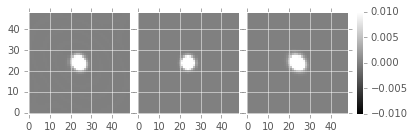

In [20]:
P_D, F_D = dit.computeZOGYDiffimPsf(im1, im2, P_r, P_n)
print F_D
dit.plotImageGrid((P_D, P_r, P_n), clim=(-0.01,0.01))

Work on variance planes.

LSSTSW has not been set up.
(0.01078972482564104, 0.97870120675830719, -4.5284690834150716, 9.1272042650713381)
(6.9142543371464464e-05, 0.0061983037166391149, -0.028623117289243976, 0.063284775402083812)
(245.89925013100506, 279.36159004560153) 9.12720426507
29


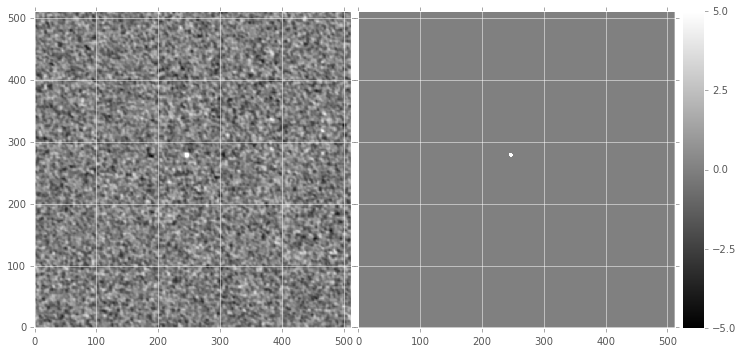

In [8]:
reload(dit);

S_corr, S, D, P_D, F_D = dit.performZOGY_Scorr(im1, im2, im1_var, im2_var, P_r, P_n)
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
#dit.plotImageGrid((S_corr, S, var1c, var2c), clim=(-2,2))
print changedCentroid, S_corr[np.rint(changedCentroid[1]).astype(int), np.rint(changedCentroid[0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((S_corr, ((S_corr > 5.)*5.0 + (S_corr < -5.)*-5.0)), clim=(-5.,5.))

Try the matched filtering with the A&L diffim...

(-0.0028586869121759238, 0.95882182311560049, -4.5176044410547567, 9.0801944756437312)
(-1.8018251138964042e-05, 0.0060756716897928734, -0.028554445089686759, 0.062958826307571894)
(245.89925013100506, 279.36159004560153) 9.08019447564
26


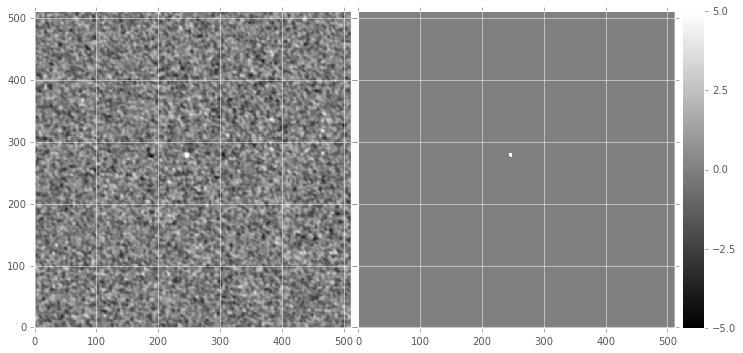

In [9]:
S_corr, S, D, P_D, F_D = dit.performZOGY_Scorr(im1, im2, im1_var, im2_var, P_r, P_n, D=D_AL)
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
#dit.plotImageGrid((S_corr, S, var1c, var2c), clim=(-2,2))
print changedCentroid, S_corr[np.rint(changedCentroid[1]).astype(int), np.rint(changedCentroid[0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((S_corr, ((S_corr > 5.)*5.0 + (S_corr < -5.)*-5.0)), clim=(-5.,5.))